In [1]:
!pip install -q transformers datasets tokenizers

     |████████████████████████████████| 1.3MB 4.9MB/s 
     |████████████████████████████████| 153kB 34.3MB/s 
     |████████████████████████████████| 2.9MB 25.1MB/s 
     |████████████████████████████████| 1.1MB 53.5MB/s 
     |████████████████████████████████| 890kB 51.3MB/s 
     |████████████████████████████████| 245kB 53.4MB/s 
     |████████████████████████████████| 17.7MB 200kB/s 
ERROR: transformers 3.4.0 has requirement tokenizers==0.9.2, but you'll have tokenizers 0.9.4 which is incompatible.


# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [2]:
device = "cuda" if torch.cuda.is_available else "cpu"

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [3]:
emotion_dataset = load_dataset("emotion")

Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/5276a3f9a2c014ee528f5cca7ad34f185b886acd0f60fe18c61c6768662ca828)


Посмотри, из чего состоит `emotion_dataset`:

In [4]:
emotion_dataset

DatasetDict({'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000), 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000), 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)})

In [5]:
emotion_dataset["train"]

Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000)

In [6]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [7]:
emotion_dataset["train"]["label"][0]

'sadness'

In [8]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [9]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [10]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [11]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [12]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [13]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [14]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [15]:
# Если надо, попрактикуйся работать с токенайзером здесь

In [16]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]['text'][idx]
        label = self.dataset[self.part]['label'][idx]
        tokenizer_output = self.tokenizer.encode_plus(text,max_length=128, padding="max_length",return_tensors="pt")
        target = self.label2num[label]

        return {
            "input_ids": tokenizer_output["input_ids"], 
            "mask": tokenizer_output['attention_mask'],
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [17]:
train_dataset = TweetDataset("train")
valid_dataset = TweetDataset("validation") # validation
test_dataset = TweetDataset("test")

In [18]:
batch_size = 64 # Задай batch_size

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,batch_size = batch_size
)
valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset,batch_size = batch_size
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,batch_size = batch_size
)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [19]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста
#model_1 = GPT2ForSequenceClassification(config=config)

Подготовь оптимайзер и критерий:

In [24]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_0.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [25]:
tokens =train_dataset[0]['input_ids'].to(device)  # Получи токены из датасета
mask = train_dataset[0]['mask'].to(device) # Получи маску из датасета

model_0(tokens,attention_mask=mask) # Посмотри на аутпут

(tensor([[-0.0819, -0.3218,  0.4788,  0.3486, -0.2513, -0.8038,  1.1216,  0.3210]],
        device='cuda:0', grad_fn=<IndexBackward>),
 (tensor([[[[[-5.2601e-02,  3.2977e-01,  1.8571e-02,  ..., -1.4976e-01,
               2.8371e-01,  1.6537e-01],
             [ 9.7218e-01,  4.0984e-01,  7.8758e-02,  ..., -1.4519e-01,
              -1.4910e-02,  1.1305e+00],
             [-2.4860e-01,  7.0722e-01, -3.1623e-01,  ..., -7.8385e-01,
              -6.7609e-01,  3.3241e-01],
             ...,
             [-5.3533e-02, -7.0403e-01,  7.9605e-01,  ...,  2.3973e-01,
               6.0859e-01, -3.0045e-01],
             [-4.6612e-01,  2.4748e-01,  1.3368e+00,  ...,  2.2948e-01,
               2.8718e-01, -3.5696e-01],
             [-7.2533e-01, -5.3922e-01,  1.2791e+00,  ...,  1.4257e+00,
              -1.2594e-01,  9.7344e-01]],
  
            [[ 7.7776e-02,  6.3566e-03, -5.7771e-02,  ...,  5.3206e-03,
              -3.4203e-01,  5.7960e-01],
             [ 5.3820e-01, -9.0736e-01, -5.5513e-01,

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [ ]:
!nvidia-smi

In [26]:
def acc_count(tensor,target):
  sm = torch.softmax(tensor,dim=1)
  win = sm.argmax(dim=1)
  cor = (win==target)
  accuracy = cor.sum().float() / float( target.size(0) )
  return accuracy



In [29]:
from tqdm.notebook import tqdm


num_epochs = 10

# Train loop
for e in range(num_epochs):
    model_0.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        target = batch['target'].to(device)
        input_ids = batch['input_ids'].squeeze(1).to(device)
        mask  = batch['mask'].squeeze(1).to(device)
        optimizer.zero_grad()
        preds = model_0(input_ids=input_ids,attention_mask=mask,labels=target)
        train_loss += criterion(preds[1],target)
        loss = criterion(preds[1],target)
        loss.backward()
        optimizer.step()
        
    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in valid_loader:
          target = batch['target'].to(device)
          input_ids = batch['input_ids'].squeeze(1).to(device)
          mask  = batch['mask'].squeeze(1).to(device)
          preds = model_0(input_ids=input_ids,attention_mask=mask,labels=target)
          valid_loss += criterion(preds[1], target)
          valid_acc += acc_count(preds[1],target).item() #ToDo
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
      target = batch['target'].to(device)
      input_ids = batch['input_ids'].squeeze(1).to(device)
      mask  = batch['mask'].squeeze(1).to(device)
      preds = model_0(input_ids=input_ids,attention_mask=mask,labels=target)
      test_acc += acc_count(preds[1],target).item()
print(f"Test Acc: {test_acc / len(test_loader)}")


Train Loss: 1.2884620428085327,Valid Loss: 1.0550025701522827,Valid Acc: 0.5986328125



Train Loss: 0.9329234957695007,Valid Loss: 0.796749472618103,Valid Acc: 0.71728515625



Train Loss: 0.656817615032196,Valid Loss: 0.6676145792007446,Valid Acc: 0.7734375



Train Loss: 0.5009000301361084,Valid Loss: 0.587776780128479,Valid Acc: 0.80078125



Train Loss: 0.3803776204586029,Valid Loss: 0.5715213418006897,Valid Acc: 0.8134765625



Train Loss: 0.30196601152420044,Valid Loss: 0.5668717622756958,Valid Acc: 0.81298828125



Train Loss: 0.24303242564201355,Valid Loss: 0.5465940833091736,Valid Acc: 0.82666015625



Train Loss: 0.19521433115005493,Valid Loss: 0.48178496956825256,Valid Acc: 0.8544921875



Train Loss: 0.16167984902858734,Valid Loss: 0.48972684144973755,Valid Acc: 0.8564453125



Train Loss: 0.13153409957885742,Valid Loss: 0.4693002998828888,Valid Acc: 0.86669921875
Test Acc: 0.84521484375


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [30]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn)

In [31]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [32]:
text = emotion_dataset['train']['text'][5] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

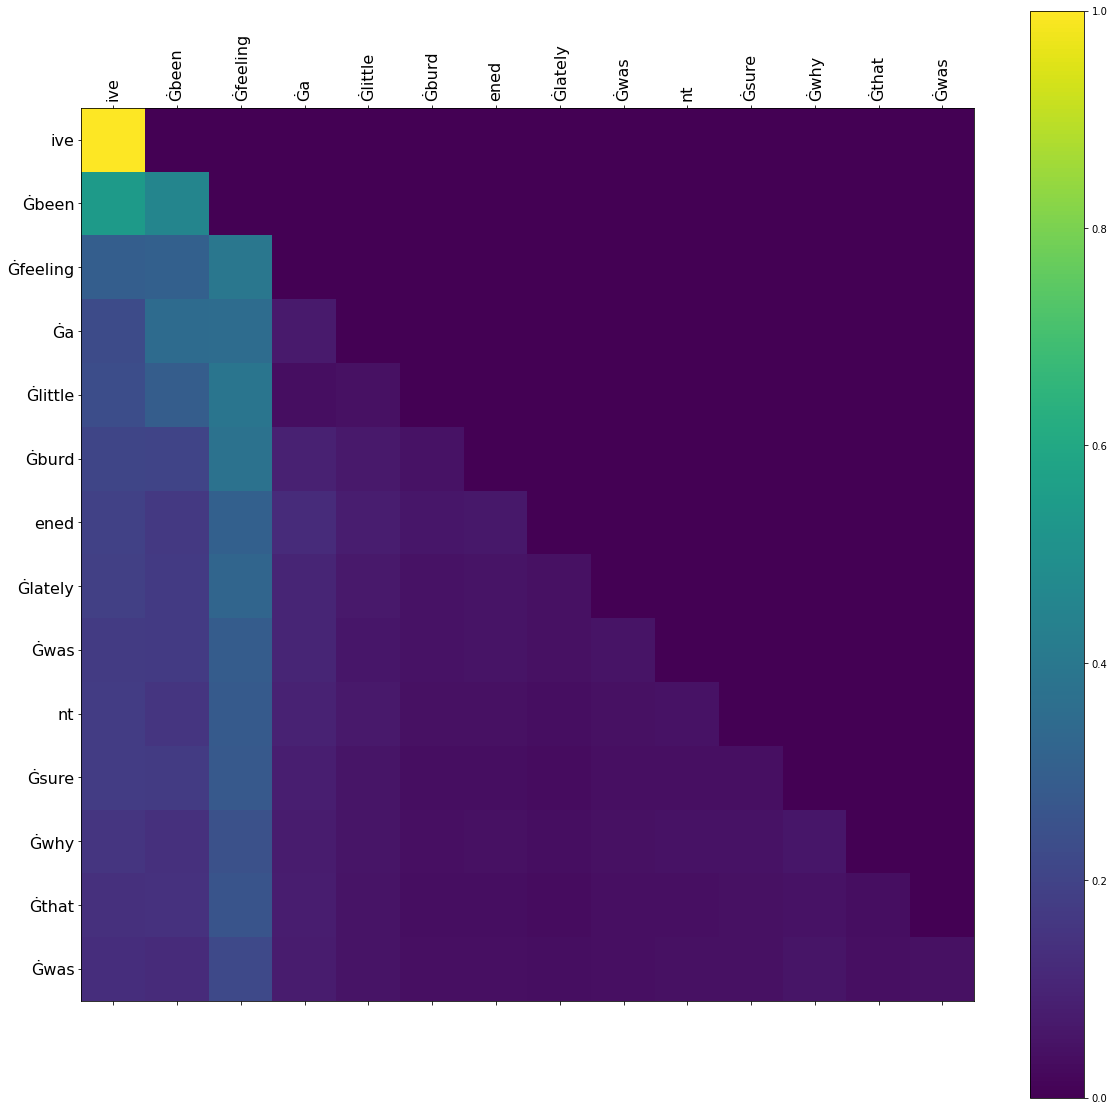

In [33]:
attns = get_attention_matrixes(model_0, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [34]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
).to(device)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_1.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [44]:
from tqdm.notebook import tqdm


num_epochs = 5

# Train loop
for e in range(num_epochs):
    model_1.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        target = batch['target'].to(device)
        input_ids = batch['input_ids'].squeeze(1).to(device)
        mask  = batch['mask'].squeeze(1).to(device)
        optimizer.zero_grad()
        preds = model_1(input_ids=input_ids,attention_mask=mask,labels=target)
        train_loss += criterion(preds[1],target)
        loss = criterion(preds[1],target)
        loss.backward()
        optimizer.step()
        
    valid_loss = 0
    valid_acc = 0
    model_1.eval()
    with torch.no_grad():
        for batch in valid_loader:
          target = batch['target'].to(device)
          input_ids = batch['input_ids'].squeeze(1).to(device)
          mask  = batch['mask'].squeeze(1).to(device)
          preds = model_1(input_ids=input_ids,attention_mask=mask,labels=target)
          valid_loss += criterion(preds[1], target)
          valid_acc += acc_count(preds[1],target).item() #ToDo
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
      target = batch['target'].to(device)
      input_ids = batch['input_ids'].squeeze(1).to(device)
      mask  = batch['mask'].squeeze(1).to(device)
      preds = model_1(input_ids=input_ids,attention_mask=mask,labels=target)
      test_acc += acc_count(preds[1],target).item()
print(f"Test Acc: {test_acc / len(test_loader)}")


Train Loss: 0.3590471148490906,Valid Loss: 0.26334208250045776,Valid Acc: 0.90625



Train Loss: 0.25439268350601196,Valid Loss: 0.2059095948934555,Valid Acc: 0.91943359375



Train Loss: 0.2022533118724823,Valid Loss: 0.18330112099647522,Valid Acc: 0.92138671875



Train Loss: 0.16923250257968903,Valid Loss: 0.1707678735256195,Valid Acc: 0.92724609375



Train Loss: 0.1480761021375656,Valid Loss: 0.1610383689403534,Valid Acc: 0.92919921875
Test Acc: 0.92138671875


Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [45]:
text = emotion_dataset['train']['text'][5] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

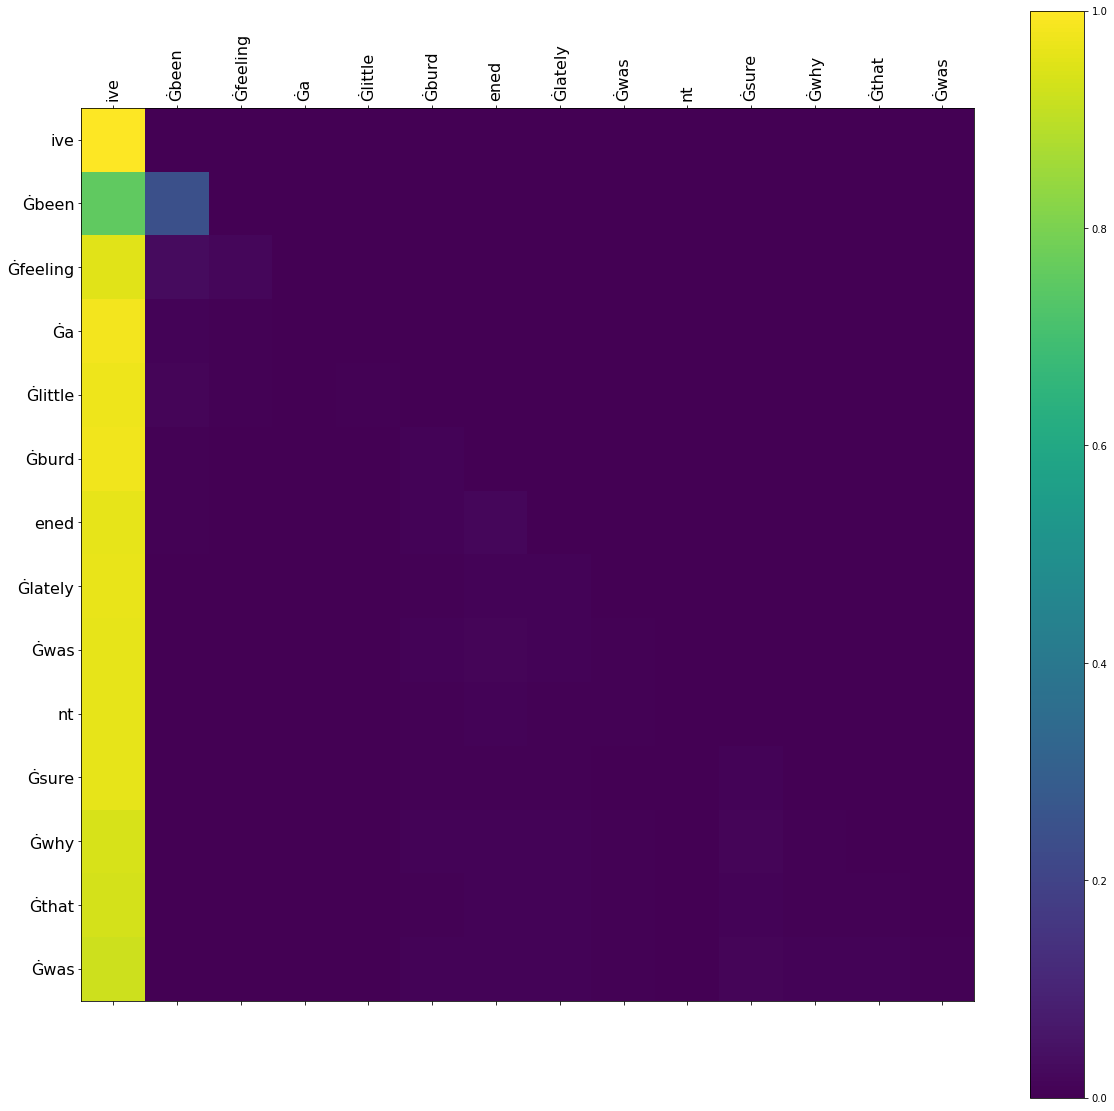

In [46]:
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше? 
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?

< твой отчет/ответы >

In [ ]:
Второй подход оказался лучше.Время трейна такое же, а точность выше уже на третьей итерации.
Обученная модель больше сфокусирована.